# türkiye big mac fiyatı ve aylık gaz fiyatının m^3/TL cinsinden değerininin yıllara göre ilişkisini görselleştiren bir çalışma

In [32]:
# gerekli kütüphaneler
%pip install pandas matplotlib -q


[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## veri çıkarma

### 1.1 big mac

theeconomist kaynaklı big mac indeksi dosyasından türkiye için olan verileri temiz bir dosyaya aktarma işlemi. gaz veri setinde türk lirası kullanıldığı için bu karşılaştırmada local_price önemli

In [ ]:
import pandas as pd


df = pd.read_csv('../big-mac-raw-index.csv')

df = df[df['iso_a3'] == 'TUR']

df = df[['date', 'local_price']]

df.to_csv('turkey.csv', index=False)


print(df.head())

print(df.columns)

print(df.info())

print(df.describe())

print(df.shape)


           date  local_price
86   2002-04-01    4000000.0
118  2003-04-01    3750000.0
156  2004-05-01    3950000.0
196  2005-06-01          4.0
231  2006-01-01          4.1
Index(['date', 'local_price'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 86 to 1887
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         40 non-null     object 
 1   local_price  40 non-null     float64
dtypes: float64(1), object(1)
memory usage: 960.0+ bytes
None
        local_price
count  4.000000e+01
mean   2.925244e+05
std    1.040737e+06
min    4.000000e+00
25%    6.575000e+00
50%    1.075000e+01
75%    2.124000e+01
max    4.000000e+06
(40, 2)


### 1.2 gaz fiyatı

istanbul istatistik ofisi kaynaklı aylık perakende gaz satış fiyatlandırılması veri setini kullanıyoruz. tahsis edilen verilerin yapısı analize hiç elverişli olmadığından kullanacağımız nihai verileri veri setini temizleyerek elde ediyoruz.


In [ ]:
# veri temizliği

df_raw = pd.read_csv(
    "aylk-perakende-gaz-sat-fiyatlandrlmas.csv",
    encoding="latin1",      # tükçe karakterler için
    header=None
)

# kolonları 3'e ayır
split = df_raw[0].str.split("\t", expand=True) # tab kullanarak ayır

# ilk satır başlıklar olarak kullan
df = split.iloc[1:].copy()
df.columns = split.iloc[0]   

# ayları sayılara endeksle
month_map = {
    "Ocak": 1,
    "Şubat": 2, "Subat": 2, "Þubat": 2, #syntax hatalarını yokla
    "Mart": 3,
    "Nisan": 4,
    "Mayıs": 5, "Mayis": 5, "Mayýs": 5, #syntax hatalarını yokla
    "Haziran": 6,
    "Temmuz": 7,
    "Ağustos": 8, "Agustos": 8, #syntax hatalarını yokla
    "Eylül": 9, "Eylul": 9,
    "Ekim": 10,
    "Kasım": 11, "Kasim": 11, #syntax hatalarını yokla
    "Aralık": 12, "Aralik": 12, #syntax hatalarını yokla
}

df["month_num"] = df["Ay"].map(month_map) # ay isimlerini sayılara çevir

mask = df["month_num"].notna() # geçerli ay numaraları olan satırları seç
df = df[mask].copy() # geçerli satırları koru

df["Yil"] = df["Yil"].astype(int) # yıl kolonunu int yap
df["month_num"] = df["month_num"].astype(int) # ay numarasını int yap

df["date"] = pd.to_datetime(
    df["Yil"].astype(str) + "-" +
    df["month_num"].astype(str) + "-01",
    format="%Y-%m-%d"
) # tarih kolonunu oluştur

# fiyat kolonunu oluştur
df["gas_price"] = (
    df["TL/m³"] # berbat format
    .str.replace(",", ".", regex=False)
    .astype(float)
)

# tarih ve fiyat
final_df = df[["date", "gas_price"]].copy()
final_df["date"] = final_df["date"].dt.strftime("%Y-%m-%d")


final_df.to_csv("gas.csv", index=False)


print(final_df.head())

print(final_df.dtypes)

print(final_df.columns)

print(final_df.info())

print(final_df.describe())

print(final_df.shape)

0        date  gas_price
1  2015-01-01   1.002100
2  2015-02-01   1.001107
3  2015-03-01   1.001535
4  2015-04-01   1.003096
5  2015-05-01   1.004478
0
date          object
gas_price    float64
dtype: object
Index(['date', 'gas_price'], dtype='object', name=0)
<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 1 to 198
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       132 non-null    object 
 1   gas_price  132 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.1+ KB
None
0       gas_price
count  132.000000
mean     2.783884
std      1.564624
min      0.928449
25%      1.012964
50%      2.851619
75%      4.244957
max      5.082003
(132, 2)


## 2. birleştirme

big mac ve gaz fiyatı verilerini tarih sütununa göre birleştiriyoruz.


In [35]:
df1 = pd.read_csv('turkey.csv')
df2 = pd.read_csv('gas.csv')

df = pd.merge(df1, df2, on='date', how='inner')


df.to_csv('merged.csv', index=False)


print(df.head())

print(df.columns)

print(df.info())

print(df.describe())

print(df.shape)


         date  local_price  gas_price
0  2015-01-01         9.25   1.002100
1  2015-07-01        10.25   1.007878
2  2016-01-01        10.25   1.008962
3  2016-07-01        10.75   1.012308
4  2017-01-01        10.75   0.932924
Index(['date', 'local_price', 'gas_price'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         20 non-null     object 
 1   local_price  20 non-null     float64
 2   gas_price    20 non-null     float64
dtypes: float64(2), object(1)
memory usage: 608.0+ bytes
None
       local_price  gas_price
count    20.000000  20.000000
mean     33.260500   2.301597
std      29.260505   1.503055
min       9.250000   0.932924
25%      10.750000   1.006433
50%      14.490000   1.565990
75%      75.000000   4.143574
max      75.000000   4.584340
(20, 3)


## 3. görselleştirme

birleştirilmiş verilerle bir görselleştirme oluşturarak iki verinin yıllara göre ilişkisini inceleme

plot saved to big-mac-and-gas-price.png


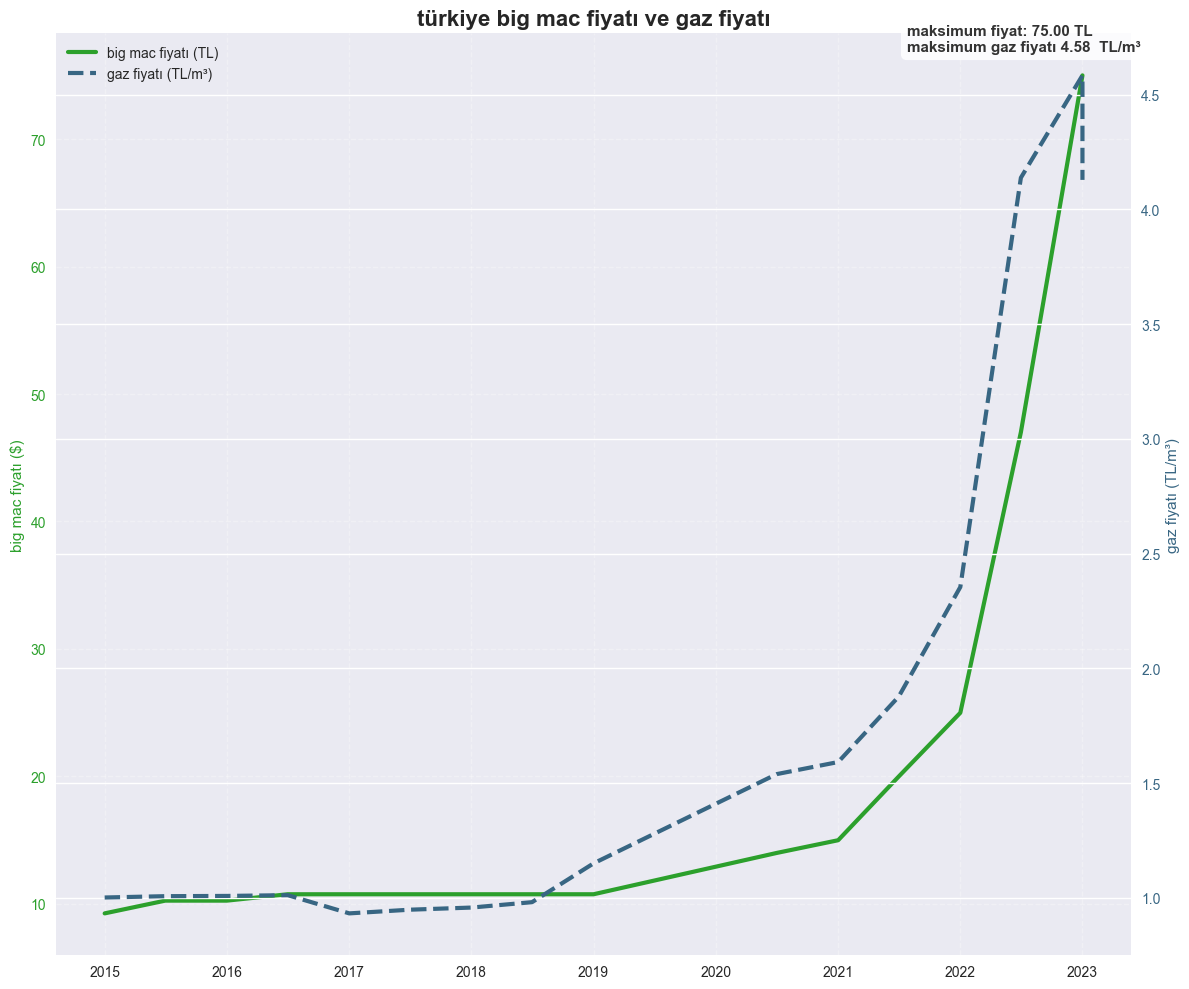

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#stil ayarı
plt.style.use('seaborn-v0_8')


df = pd.read_csv('merged.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


fig, ax_left = plt.subplots(figsize=(12, 10))
ax_right = ax_left.twinx()

# renkler
price_color = '#2ca02c'
gas_color = '#386683' #gaz mavisi :p

# solda big mac fiyatı
ax_left.plot(
    df['date'],
    df['local_price'],
    color=price_color,
    linewidth=3,
    label='big mac fiyatı (TL)'
)

# sağda gaz fiyatı
ax_right.plot(
    df['date'],
    df['gas_price'],
    color=gas_color,
    linewidth=3,
    linestyle='--',
    label='gaz fiyatı (TL/m³)'
)

# etiketler
ax_left.set_ylabel('big mac fiyatı ($)', color=price_color, fontsize=11)
ax_right.set_ylabel('gaz fiyatı (TL/m³)', color=gas_color, fontsize=11)

# eksen renkleri
ax_left.tick_params(axis='y', colors=price_color)
ax_right.tick_params(axis='y', colors=gas_color)

# tarih formatı
ax_left.xaxis.set_major_locator(mdates.YearLocator())
ax_left.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)



# maksimum değerleri bul
max_price_idx = df['local_price'].idxmax()
max_price_date = df.loc[max_price_idx, 'date']
max_price_value = df.loc[max_price_idx, 'local_price']

max_gas_idx = df['gas_price'].idxmax()
max_gas_date = df.loc[max_gas_idx, 'date']
max_gas_value = df.loc[max_gas_idx, 'gas_price']


ax_left.grid(alpha=0.3, linestyle='--')

# maksimum değerleri göster
fig.text(
    0.76,
    0.94,
    f'maksimum fiyat: {max_price_value:.2f} TL\nmaksimum gaz fiyatı {max_gas_value:.2f}  TL/m³',
    ha='left',
    va='bottom',
    fontsize=11,
    fontweight='bold',
    color='#333333',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85, edgecolor='none')
)

# legend 
lines_left, labels_left = ax_left.get_legend_handles_labels()
lines_right, labels_right = ax_right.get_legend_handles_labels()
ax_left.legend(
    lines_left + lines_right,
    labels_left + labels_right,
    loc='upper left'
)

# başlık ve kaydetme
plt.title('türkiye big mac fiyatı ve gaz fiyatı', fontsize=16, fontweight='bold')
fig.tight_layout()
fig.savefig('big-mac-and-gas-price.png', dpi=300)
print('plot saved to big-mac-and-gas-price.png')

plt.show()
